In [1]:
import os, array
import numpy as np
import random
import math
from operator import itemgetter
from ripser import ripser, plot_dgms
import scipy

In [2]:
#imageNames = [name for name in os.listdir('./vanhateren_iml')]

In [3]:
'''for filename in imageNames:
    
    if filename == 'readIML.m':
        #skip this file
        continue
    
    currentFiles = [name for name in os.listdir('./ImageArrays')]
    
    if filename + '.csv' in currentFiles:
        continue
    
    fullPath = './vanhateren_iml/' + filename
    with open(fullPath, 'rb') as handle:
        s = handle.read()
    arr = array.array('H', s)
    arr.byteswap()
    img = np.array(arr, dtype='uint16').reshape(1024, 1536)
    
    np.savetxt('./ImageArrays/' + filename + '.csv', img, delimiter=",")
'''

'for filename in imageNames:\n    \n    if filename == \'readIML.m\':\n        #skip this file\n        continue\n    \n    currentFiles = [name for name in os.listdir(\'./ImageArrays\')]\n    \n    if filename + \'.csv\' in currentFiles:\n        continue\n    \n    fullPath = \'./vanhateren_iml/\' + filename\n    with open(fullPath, \'rb\') as handle:\n        s = handle.read()\n    arr = array.array(\'H\', s)\n    arr.byteswap()\n    img = np.array(arr, dtype=\'uint16\').reshape(1024, 1536)\n    \n    np.savetxt(\'./ImageArrays/\' + filename + \'.csv\', img, delimiter=",")\n'

In [3]:
def extract_patches(img, xLength, yLength, patchLength, numPatches):
    
    patches = []
    
    random.seed(12345)
    
    for i in range(numPatches):
    
        xIndex = random.randint(0,xLength - patchLength)
        yIndex = random.randint(0,yLength - patchLength)

        patch = sample[xIndex:xIndex + patchLength, yIndex:yIndex + patchLength]
    
        patches.append(patch)
    
    return np.array(patches)

In [4]:
def compute_D_norm(patch, D):
    
    #Turn patch from 3x3 matrix to flat vector
    patch = patch.flatten()

    xTD = np.dot(patch.T,D)
    
    xTDx = np.dot(xTD,patch)

    return math.sqrt(xTDx)
        

In [5]:
def pre_process_patches(patches):
    #Returns a tuple of the form
    #(processedPatch, DNorm)
    
    processedPatchesAndDNorm = []
    
    D = np.matrix([
        [2,-1,0,-1,0,0,0,0,0],
        [-1,3,-1,0,-1,0,0,0,0],
        [0,-1,2,0,0,-1,0,0,0],
        [-1,0,0,3,-1,0,-1,0,0],
        [0,-1,0,-1,4,-1,0,-1,0],
        [0,0,-1,0,-1,3,0,0,-1],
        [0,0,0,-1,0,0,2,-1,0],
        [0,0,0,0,-1,0,-1,3,-1],
        [0,0,0,0,0,-1,0,-1,2]
    ])
    
    for patch in patches:
        
        logVals = []
        
        for row in patch:
            
            for pix in row:
            
                logPix = math.log(pix)
                logVals.append(logPix)
        
        patchLength = patch.shape[0]
        logPatch = np.array(logVals).reshape(patchLength,patchLength)
        
        avg = np.mean(logPatch)
        
        averagedPatch = np.array([val - avg for val in logPatch]).reshape(patchLength,patchLength)
        
        DNorm = compute_D_norm(averagedPatch, D)
        
        tup = (averagedPatch,DNorm)
        processedPatchesAndDNorm.append(tup)
            
    return processedPatchesAndDNorm
         

In [6]:
def normalizeVectors(patchesAndNorms):
    #Takes a list of tuples of the form
    #(patch/vector,DNorm)
    
    normalizedPatches = []
    for patchAndNorm in patchesAndNorms:
        
        DNorm = patchAndNorm[1]
        
        normalizedPatch = []
        for pix in patchAndNorm[0]:
            normalized = pix / DNorm
            
            normalizedPatch.append(normalized)
        
        normalizedPatch = np.array(normalizedPatch)
            
        normalizedPatches.append(normalizedPatch)
            
    return np.array(normalizedPatches)   

In [7]:
def change_coordinates(patches):
    
    e1 = (1/math.sqrt(6))*np.array([1,0,-1,1,0,-1,1,0,-1]).T
    e2 = (1/math.sqrt(6))*np.array([1,1,1,0,0,0,-1,-1,-1]).T
    e3 = (1/math.sqrt(54))*np.array([1,-2,1,1,-2,1,1,-2,1]).T
    e4 = (1/math.sqrt(54))*np.array([1,1,1,-2,-2,-2,1,1,1]).T
    e5 = (1/math.sqrt(8))*np.array([1,0,-1,0,0,0,-1,0,1]).T
    e6 = (1/math.sqrt(48))*np.array([1,0,-1,-2,0,2,1,0,-1]).T
    e7 = (1/math.sqrt(48))*np.array([1,-2,1,0,0,0,-1,2,-1]).T
    e8 = (1/math.sqrt(216))*np.array([1,-2,1,-2,4,-2,1,-2,1]).T
    
    A = np.matrix(np.column_stack((e1,e2,e3,e4,e5,e6,e7,e8)))
    
    lam = np.matrix([
        [(1/np.linalg.norm(e1)),0,0,0,0,0,0,0],
        [0,(1/np.linalg.norm(e2)),0,0,0,0,0,0],
        [0,0,(1/np.linalg.norm(e3)),0,0,0,0,0],
        [0,0,0,(1/np.linalg.norm(e4)),0,0,0,0],
        [0,0,0,0,(1/np.linalg.norm(e5)),0,0,0],
        [0,0,0,0,0,(1/np.linalg.norm(e6)),0,0],
        [0,0,0,0,0,0,(1/np.linalg.norm(e7)),0],
        [0,0,0,0,0,0,0,(1/np.linalg.norm(e8))]
    ])
    
    lamAT = np.dot(lam, A.T)
    
    changedPatches = []
    for patch in patches:
        v = np.dot(A.T, patch.flatten())
        
        ary = np.squeeze(np.asarray(v))
        
        changedPatches.append(ary)
    
    return np.array(changedPatches)

In [16]:
cnt = 0
for file in os.listdir('./ImageArrays'):
       
    cnt += 1
    if cnt < 1260:
        continue
        
    if file == '.ipynb_checkpoints':
        #Don't want this file
        continue

    try:
        
        sample = np.loadtxt('./ImageArrays/' + file, delimiter=',')

        patches = extract_patches(sample, 1024, 1536, 3, 5000)

        patchesAndNorm = pre_process_patches(patches)

        sortedLst = sorted(patchesAndNorm,key=itemgetter(1),reverse=True)

        top20Index = int(1000)

        selectedPatchesAndNorms = sortedLst[:top20Index]

        normalizedPatches = normalizeVectors(selectedPatchesAndNorms)

        patchesChangedCoordinates = change_coordinates(normalizedPatches)

        np.savetxt('./Patches/' + file + 'Patches.csv', patchesChangedCoordinates, delimiter=",", newline="\n")

    except ValueError:
        
        continue
        
    '''patchCnt = 1
    
    for patch in patchesChangedCoordinates:
        
        fileName = file + 'Patch' + str(patchCnt)
        
        #currentFiles = [name for name in os.listdir('./ImagePatches !!DONT OPEN!!')]
        #if fileName in currentFiles:
        #    continue

        np.savetxt('./ImagePatches !!DONT OPEN!!/' + fileName + '.csv', patch, delimiter=",")
        
        patchCnt += 1

'''

In [3]:
import csv
M = []

for file in os.listdir('./Patches'):
    
    if file == '.ipynb_checkpoints':
        #Don't want this file
        continue
    
    
    with open('./Patches/' + file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            M.append(np.array(row))

M = np.array(M)

In [4]:
indices = np.random.randint(0,4150001,50000)

In [5]:
subset  = np.array([M[i] for i in indices])

In [6]:
from sklearn.neighbors import KDTree

tree = KDTree(subset)

In [7]:
dist, index = tree.query(subset, k=15)

In [8]:
dist_index_tuples = list(zip(dist,index))
sorted_dist_index_tuples = sorted(dist_index_tuples, key=lambda x: x[0][-1])

In [9]:
thirty_percent_index = int(len(sorted_dist_index_tuples)*.3)

In [10]:
thirty_percent_tuples = np.array(sorted_dist_index_tuples[:thirty_percent_index])

In [11]:
small_indices = [int(t[1][0]) for t in thirty_percent_tuples]

In [12]:
point_cloud = np.array([M[i] for i in small_indices])

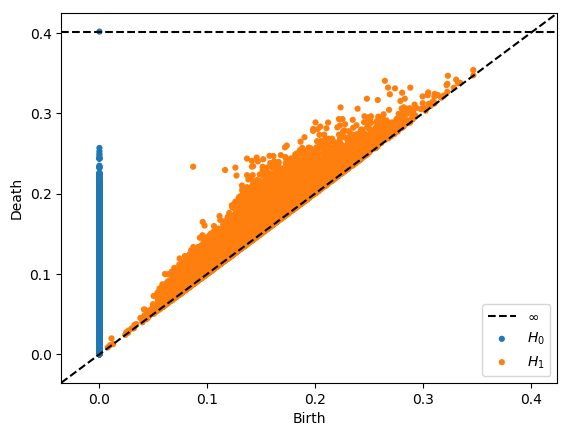

In [13]:
diagrams = ripser(point_cloud)['dgms']
plot_dgms(diagrams)